In [1]:
import nglview as nv
import mdtraj as md
from pathlib import Path
import mdtraj as md
from tqdm import tqdm 
from pathlib import Path
import re
import os 
def _natural_key(path: Path):
    """
    Return a list that lets `sorted()` put Path objects
    in “human” (natural) order: struc2.pdb < struc11.pdb.
    """
    # Split the file stem into text and digit runs: ["struc", "2", ""].
    # Digits are converted to int, everything else to lowercase str.
    return [
        int(s) if s.isdigit() else s.lower()
        for s in re.split(r'(\d+)', path.stem)
    ]

def load_folder_as_trajectory(folder_path: str) -> md.Trajectory:
    """
    Combine all PDB files in `folder_path` into one MDTraj Trajectory,
    using natural sorting so that struc2.pdb < struc11.pdb.

    Parameters
    ----------
    folder_path : str
        Directory containing PDB files with a consistent topology.

    Returns
    -------
    md.Trajectory
    """
    folder = Path(folder_path).expanduser().resolve()
    # if os.path.isfile(f'{folder_path}/traj.xtc'):
    #     print('traj already exists')
    #     return
    pdb_files = sorted(folder.glob("*.pdb"), key=_natural_key)
    if not pdb_files:
        raise ValueError(f"No PDB files found in {folder}")

    # md.load(List[str]) concatenates along the time axis
    try:
        traj = md.load([str(p) for p in pdb_files])
        print('here')
    except Exception as err:
        # Fallback: load one file at a time and join
        frames = [md.load(str(pdb_files[0]))]
        for pdb_file in tqdm(pdb_files[1:]):
            frames.append(md.load(str(pdb_file)))
        traj = frames[0].join(frames[1:], check_topology=True)
        if traj.n_frames != len(pdb_files):
            raise RuntimeError("Failed to concatenate PDB files") from err
    traj.save_xtc(f'{folder_path}/traj.xtc')
    return traj

proteins = ['PRB', 'GTT']
noises = ['0.003', '0.005', '0.01']
# models = ['big_model_ckp-15_euler_noise-{}_chi_0.2', 'big_model_ckp-15_noise-{}_chi_0.25']
# for prot in proteins:
#     for noise in noises:
#         for model in models:
#             print(model.format(noise))
#             load_folder_as_trajectory(f'outputs/{prot}/{model.format(noise)}/')

# for prot in proteins:
#     load_folder_as_trajectory(f'outputs/{prot}/n2503_post_ckp-7000_noise-0.003_chi_0.25/')
#     load_folder_as_trajectory(f'outputs/{prot}/n2505_post_ckp-7000_noise-0.005_chi_0.25/')
#     load_folder_as_trajectory(f'outputs/{prot}/n2510_post_ckp-7000_noise-0.01_chi_0.25/')
#     load_folder_as_trajectory(f'outputs/{prot}/big_model_ckp-15_noise-0.003_chi_0.25/')
#     load_folder_as_trajectory(f'outputs/{prot}/big_model_ckp-15_noise-0.005_chi_0.25/')
#     load_folder_as_trajectory(f'outputs/{prot}/big_model_ckp-15_noise-0.01_chi_0.25/')
# load_folder_as_trajectory('outputs/PRB/n005_post_ckp-2500_noise-0.005')

In [400]:
import nglview as nv
import mdtraj as md

def slice(traj, s):
    return traj.atom_slice(traj.top.select(s))
def strip_disulfides_in_place(topology: md.Topology) -> int:
    """
    Remove every Cys–Cys S–S bond from `topology` **in place**.
    Because MDTraj exposes no public bond-removal API, this
    function edits the private `_bonds` lists on the Topology and
    Atom objects.

    Returns
    -------
    int
        How many bonds were deleted.
    """
    sulfur = md.core.element.get_by_symbol('S')
    cys_names = {'CYS', 'CYX', 'CYM', 'CYT'}   # all cysteine aliases

    # Pick out the bonds to delete
    ss_bonds = [
        bond for bond in topology.bonds
        if (
            bond.atom1.element is sulfur and bond.atom2.element is sulfur
            and bond.atom1.residue.name.strip().upper() in cys_names
            and bond.atom2.residue.name.strip().upper() in cys_names
        )
    ]

    # ---- MUTATE THE INTERNAL LISTS ----
    for bond in ss_bonds:
        topology._bonds.remove(bond)

    # MDTraj builds the “bond array” lazily, so no further bookkeeping is needed
    return len(ss_bonds)

    # return len(bonds_to_remove)

# selection = f'resSeq {resids[0]} or resSeq {resids[1]}'
# selection2 = f'resSeq {resids[0]-1} or resSeq {resids[1]-1}'
resSeqs = [14, 48, 49, 50]
selection = 'resSeq ' + " or resSeq ".join([str(r) for r in resSeqs])
selection2 = 'resSeq ' + " or resSeq ".join([str(r-1) for r in resSeqs])
frame = 787
def tostr(i):
    if i < 10:
        return '00' + str(i)
    elif i < 100:
        return '0' + str(i)
    else:
        return str(i)

protein = 'dux4'
traj = md.load(f'outputs/{protein}/big_model_ckp-15_noise-0.003/frame_00{tostr(frame)}_1.pdb')
traj2 = md.load(f'outputs/{protein}/r03_post_ckp-2500_noise-0.003/frame_00{tostr(frame)}_1.pdb')
traj3 = md.load(f'data/hpack_{protein}/struc{frame}.pdb')

strip_disulfides_in_place(traj.top)
strip_disulfides_in_place(traj2.top)
strip_disulfides_in_place(traj3.top)

view = nv.show_mdtraj(traj)
view.clear()
view.add_ribbon(color='blue')
a = view.add_trajectory(slice(traj, selection))
a.clear_representations()
a.add_representation('ball+stick', color='beige', opacity=0.6, radius=0.2)
a = view.add_trajectory(slice(traj2, selection))
a.clear_representations()
a.add_representation('ball+stick',  opacity=1, radius=0.2)
a = view.add_trajectory(slice(traj3, selection2))
a.clear_representations()
a.add_representation('ball+stick', color='green', opacity=0.4, radius=0.2)
view

NGLWidget()

In [271]:
md.load('outputs/Q31PX7/lr5_post_ckp-2000/frame_00461_1.pdb')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [334]:
full_traj = md.load('../dux4_f19l/samples.xtc', top='../dux4_f19l/topology.pdb')
nv.show_mdtraj(full_traj)

NGLWidget(max_frame=957)

In [59]:
traj_fb = load_folder_as_trajectory('outputs/cdgmp/big_model_ckp-15_euler/')
traj_lj = load_folder_as_trajectory('outputs/cdgmp/big_model_ckp-15/')
traj_am = load_folder_as_trajectory('outputs/cdgmp/lr5_post_ckp-2000/')
traj_hp = load_folder_as_trajectory('data/hpack_cdgmp/')
traj_fb.save_xtc('outputs/cdgmp/big_model_ckp-15_euler/traj.xtc')
traj_lj.save_xtc('outputs/cdgmp/big_model_ckp-15/traj.xtc')
traj_am.save_xtc('outputs/cdgmp/lr5_post_ckp-2000/traj.xtc')
traj_hp.save_xtc('data/hpack_cdgmp/traj.xtc')

In [ ]:
traj_fb = load_folder_as_trajectory('outputs/GTT/big_model_ckp-15_euler/')
traj_lj = load_folder_as_trajectory('outputs/GTT/big_model_ckp-15/')
traj_fb.save_xtc('outputs/GTT/big_model_ckp-15_euler/traj.xtc')
traj_lj.save_xtc('outputs/GTT/big_model_ckp-15/traj.xtc')

In [305]:
# for prot in ['PRB', 'GTT']:
#     traj_fb = load_folder_as_trajectory(f'outputs/{prot}/big_model_ckp-15_euler_noise-0.003/')
#     traj_lj = load_folder_as_trajectory(f'outputs/{prot}/big_model_ckp-15_noise-0.003/')
#     traj_am = load_folder_as_trajectory(f'outputs/{prot}/lr5_post_ckp-2000_noise-0.003/')
#     traj_gt = load_folder_as_trajectory(f'data/{prot}_clean_AA/')
#     traj_fb.save_xtc(f'outputs/{prot}/big_model_ckp-15_euler_noise-0.003/traj.xtc')
#     traj_lj.save_xtc(f'outputs/{prot}/big_model_ckp-15_noise-0.003/traj.xtc')
#     traj_am.save_xtc(f'outputs/{prot}/lr5_post_ckp-2000_noise-0.003/traj.xtc')
#     traj_gt.save_xtc(f'data/{prot}_clean_AA/traj.xtc')
# traj_am_005 = load_folder_as_trajectory('outputs/GTT/n005_post_ckp-2500/')
# traj_am_005.save_xtc('outputs/GTT/n005_post_ckp-2500/traj.xtc')
# traj_am_010 = load_folder_as_trajectory('outputs/GTT/n010_post_ckp-4000/')
traj_am_010.save_xtc('outputs/GTT/n010_post_ckp-4000/traj.xtc')

In [7]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import itertools
import os
from scipy.stats import gaussian_kde
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

# Utility: Load or Generate Trajectory
def load_or_generate_trajectory(path, generate_func, top_file, num_frames):
    traj_path = os.path.join(path, 'traj.xtc')
    if os.path.exists(traj_path):
        traj = md.load(traj_path, top=top_file)
        if len(traj) < num_frames:
            traj = generate_func()
            traj.save_xtc(traj_path)
            return traj
        else:
            return traj
    else:
        traj = generate_func()
        traj.save_xtc(traj_path)
        return traj

# Main Analysis Method
def analyze_protein(protein_id, residue_numbers, atom_selections, n_boot=100, cutoff_ca_dist=1, dist_range=[0.3, 0.4], num_frames=-1, title='Hydrophobic Effect', noise=True, ground_truth=None):
    # Load four trajectories (generating if missing)
    top_file = f'outputs/{protein_id}/big_model_ckp-15_euler_noise-0.003_chi_0.2/frame_00001_1.pdb'

    fb_str = f'outputs/{protein_id}/big_model_ckp-15_euler_noise-0.003_chi_0.2'
    lj_str = f'outputs/{protein_id}/big_model_ckp-15_noise-0.003_chi_0.25'
    am_str = f'outputs/{protein_id}/n2503_post_ckp-7000_noise-0.003_chi_0.25'
    hp_str = f'data/hpack_{protein_id}/'
    
    traj_fb = load_or_generate_trajectory(fb_str + '/', 
                                          lambda: load_folder_as_trajectory(f'outputs/{protein_id}/big_model_ckp-15_euler_noise-0.003_chi_0.2/'), top_file, num_frames)

    traj_lj = load_or_generate_trajectory(lj_str + '/', 
                                          lambda: load_folder_as_trajectory(f'outputs/{protein_id}/big_model_ckp-15_noise-0.003_chi_0.25/'), top_file, num_frames)

    traj_am = load_or_generate_trajectory(am_str + '/', 
                                          lambda: load_folder_as_trajectory(f'outputs/{protein_id}/n2503_post_ckp-7000_noise-0.003_chi_0.25/'), top_file, num_frames)

    traj_hp = load_or_generate_trajectory(hp_str + '/', 
                                          lambda: load_folder_as_trajectory(f'data/hpack_{protein_id}/'), top_file, num_frames)

    


    if num_frames > 0:
        traj_fb = traj_fb[:num_frames]
        traj_lj = traj_lj[:num_frames]
        traj_am = traj_am[:num_frames]
        traj_hp = traj_hp[:num_frames]
    # for traj in [traj_fb, traj_lj, traj_am, traj_hp]:
    #     print(len(traj))
    top = traj_fb.topology

    # Selecting Atom Indices by Residue Numbers
    ca_selections = {res: top.select(f"resSeq {res} and name CA") for res in residue_numbers}
    aa_selections = {residue_numbers[i]: top.select(f"resSeq {residue_numbers[i]} and ({atom_selections[i]})") for i in range(len(residue_numbers))}
    # Validating Selections
    ca_selections = {k: v for k, v in ca_selections.items() if len(v) > 0}
    aa_selections = {k: v for k, v in aa_selections.items() if len(v) > 0}
    if len(aa_selections) < 2:
        raise ValueError("Not enough valid atom selections for analysis.")
    print(list(itertools.product(aa_selections.values())))
    ca_distances = [
        np.min(md.compute_distances(traj, list(itertools.product(*ca_selections.values()))), axis=1)
        for traj in [traj_fb, traj_lj, traj_am, traj_hp]
    ]
    # Applying CA Distance Mask
    ca_mask = ca_distances[3] < cutoff_ca_dist  # Mask based on HP trajectory
    # Computing Distances
    dist_sets = [
        np.min(md.compute_distances(traj, list(itertools.product(*aa_selections.values()))), axis=1)[ca_mask]
        for traj in [traj_fb, traj_lj, traj_am, traj_hp]
    ]

    # Bootstrap Analysis
    rng = np.random.default_rng(42)
    bootstrap_means = []
    bootstrap_fractions = []


    # Statistical Tests (Pairwise t-tests)
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 8))
    bins = np.linspace(0, 1.5, 40)
    colors = ["gold", "green", "cyan", "gray"]  # Previous colors
    labels = ["FlowBack", "FlowBack + LJ/Bonds", "FlowBack-Adjoint", "HPacker"]
    max_ = 0
    # KDE Plot
    probs = []
    prob_errors = []
    eps = 1e-10                 # avoid log(0)
    idx_lo = np.argmin(np.abs(bins - dist_range[0]))
    idx_hi = np.argmin(np.abs(bins - dist_range[1]))
    for dist, color, label in zip(dist_sets, colors, labels):
        boot_vals = []
        for _ in range(n_boot):
            resample = rng.choice(dist, size=dist.shape[0], replace=True)
            kde      = gaussian_kde(resample)
            pdf      = np.maximum(kde(bins), eps)          # safelog
            boot_vals.append(np.sum(pdf[idx_lo:idx_hi]) / 40)
        
        probs.append(np.mean(boot_vals))      # bar heights
        # print(probs) 
        prob_errors.append(np.std(boot_vals, ddof=1))        # error bars (σ)

        kde = gaussian_kde(dist)
        kde_plot = kde(bins)
        ax1.plot(bins, kde_plot, color=color, label=label, linewidth=2)
        max_ = max(np.max(kde_plot), max_)

    # ax1.axvline(0, color="k", ls="--", lw=1, label="zero")
    ax1.set_xlabel(r"Side-chain distance nm", fontsize=14)
    ax1.set_ylabel("PDF", fontsize=14)
    ax1.set_title("Side Chain Distances (KDE)")
    ax1.set_xlim(bins[0], bins[-1])
    ax1.set_ylim(-0.2, 1.3 * np.max(kde_plot))
    ax1.legend(frameon=False, fontsize=10)
    
    # Plotting Bar Chart with Error Bars
    ax2.bar(np.arange(len(labels)), probs, color='0.6', yerr=prob_errors, capsize=5)
    print(probs)
    ax2.set_xticks(np.arange(len(labels)))
    ax2.set_xticklabels(labels, rotation=45, ha='right', fontsize=16)
    ax2.set_title(f"{title} Probability", fontsize=16)
    ax2.set_ylabel("P$($" + f"{dist_range[0]}–{dist_range[1]} nm$)$", fontsize=14)
    ax2.set_yticks(ax2.get_yticks()[:-2])
    if ground_truth is not None:
        ax2.bar(len(labels), ground_truth[0], yerr=ground_truth[1], color='red')
        labels.append('Ground Truth')
        ax2.set_xticks(np.arange(len(labels)))
        ax2.set_xticklabels(labels, rotation=45, ha='right', fontsize=16)
    plt.tight_layout(pad=1)
    plt.show()


# Example Usage
# analyze_protein("ake", [118, 136], ["not backbone and element C", "not backbone and element C"], cutoff_ca_dist=1.5, dist_range=[0.42, 0.9])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[(array([553]),), (array([671]),)]
[0.4099721308969518, 0.41426000413529773, 0.43361219322829814, 0.39488403791806403]


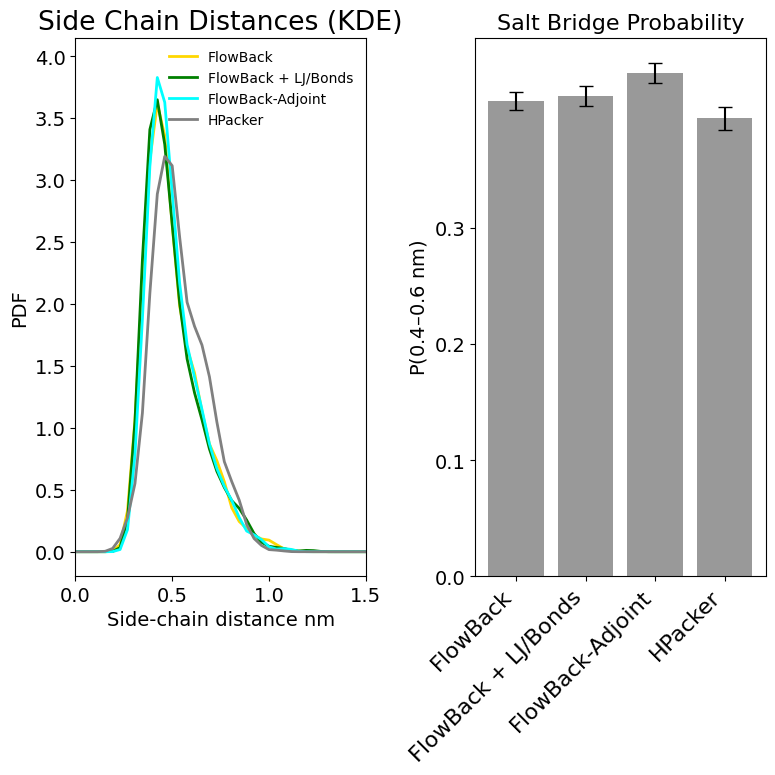

In [15]:
%load_ext autoreload
%autoreload 2
analyze_protein("Q31PX7", [71, 85], ["not backbone and name CZ", "not backbone and name CD"], dist_range=[0.4, 0.6], num_frames=993, title='Salt Bridge')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[(array([18, 19, 20, 21, 22, 23, 24]),), (array([3029, 3031]),)]
[0.38059858469813884, 0.38572744262706854, 0.4067303620746301, 0.3758280085292238]


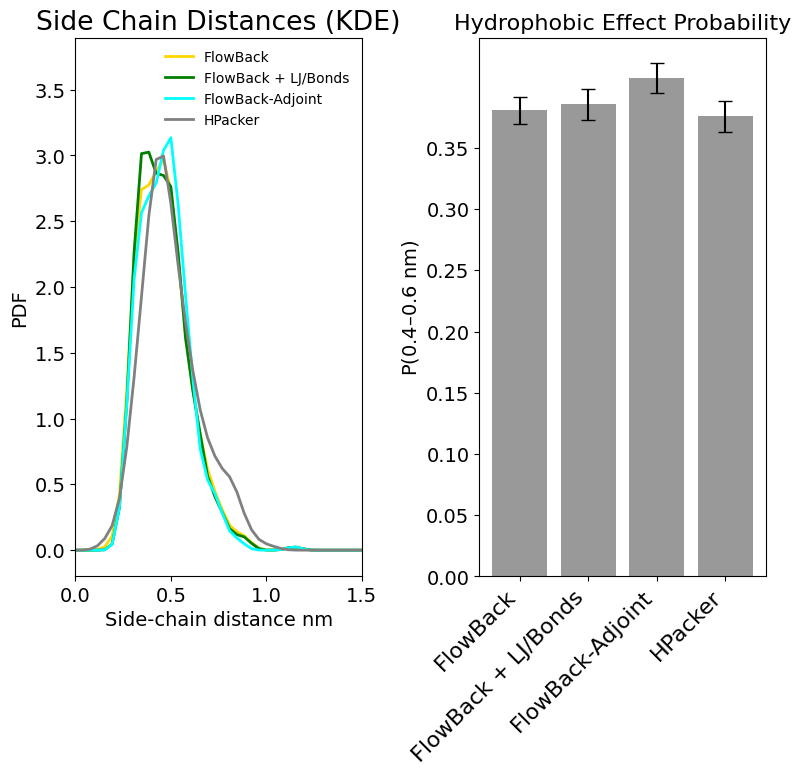

In [11]:
%load_ext autoreload
%autoreload 2
analyze_protein("cdgmp", [3, 379], ["not backbone and element C",  "not backbone and element C"], dist_range=[0.4, 0.6],  num_frames=939, title='Hydrophobic Effect' )

In [205]:
import nglview as nv
import mdtraj as md

def slice(traj, s):
    return traj.atom_slice(traj.top.select(s))
def strip_disulfides_in_place(topology: md.Topology) -> int:
    """
    Remove every Cys–Cys S–S bond from `topology` **in place**.
    Because MDTraj exposes no public bond-removal API, this
    function edits the private `_bonds` lists on the Topology and
    Atom objects.

    Returns
    -------
    int
        How many bonds were deleted.
    """
    sulfur = md.core.element.get_by_symbol('S')
    cys_names = {'CYS', 'CYX', 'CYM', 'CYT'}   # all cysteine aliases

    # Pick out the bonds to delete
    ss_bonds = [
        bond for bond in topology.bonds
        if (
            bond.atom1.element is sulfur and bond.atom2.element is sulfur
            and bond.atom1.residue.name.strip().upper() in cys_names
            and bond.atom2.residue.name.strip().upper() in cys_names
        )
    ]

    # ---- MUTATE THE INTERNAL LISTS ----
    for bond in ss_bonds:
        topology._bonds.remove(bond)

    # MDTraj builds the “bond array” lazily, so no further bookkeeping is needed
    return len(ss_bonds)

    # return len(bonds_to_remove)

# selection = f'resSeq {resids[0]} or resSeq {resids[1]}'
# selection2 = f'resSeq {resids[0]-1} or resSeq {resids[1]-1}'
resSeqs = [55, 56, 127, 131]
selection = 'resSeq ' + " or resSeq ".join([str(r) for r in resSeqs])
selection2 = 'resSeq ' + " or resSeq ".join([str(r-1) for r in resSeqs])
frame = 1
def tostr(i):
    if i < 10:
        return '00' + str(i)
    elif i < 100:
        return '0' + str(i)
    else:
        return str(i)


traj = md.load(f'outputs/P21926/big_model_ckp-15/frame_00{tostr(frame)}_1.pdb')
traj2 = md.load(f'outputs/P21926/lr5_post_ckp-2000/frame_00{tostr(frame)}_1.pdb')
traj3 = md.load(f'data/hpack_P21926/struc{frame}.pdb')

strip_disulfides_in_place(traj.top)
strip_disulfides_in_place(traj2.top)
strip_disulfides_in_place(traj3.top)

view = nv.show_mdtraj(traj)
view.clear()
view.add_ribbon(color='blue')
a = view.add_trajectory(slice(traj, selection))
a.clear_representations()
a.add_representation('ball+stick', color='beige', opacity=0.6, radius=0.2)
a = view.add_trajectory(slice(traj2, selection))
a.clear_representations()
a.add_representation('ball+stick',  opacity=1, radius=0.2)
a = view.add_trajectory(slice(traj3, selection2))
a.clear_representations()
a.add_representation('ball+stick', color='green', opacity=0.4, radius=0.2)
view

NGLWidget()

In [510]:
md.load('outputs/K0JNC6/big_model_ckp-15/traj.xtc', top='data/K0JNC6_clean_AA/frame_00000.pdb')

<mdtraj.Trajectory with 506 frames, 1680 atoms, 215 residues, without unitcells at 0x7fb5bb4ec890>

In [2]:
# One-cell batch renderer
# – Backbone cartoon: gray
# – Side-chains + CA: sticks, element-colored (C → gray, N blue, O red, S yellow …)
# – Disulfide (SG–SG) sticks removed

import pathlib, importlib, subprocess, sys

# --------------------------- user settings --------------------------
LIST_FILE   = pathlib.Path("test_proteins.txt")                # IDs (one per line)
BASE_DIR    = pathlib.Path("outputs")
SUBDIR      = "n2503_post_ckp-7000_noise-0.003_chi_0.25"
FRAME_PDB   = "frame_0_1.pdb"

IMG_W, IMG_H, DPI = 1200, 900, 300
BG_COLOR    = "white"
PYMOL_GRAY  = [0.70, 0.70, 0.70]   # RGB for carbon & backbone
NGL_GRAY    = "grey"               # NGLView cartoon color
# --------------------------------------------------------------------

def ensure(pkg, pip_name=None):
    if importlib.util.find_spec(pkg) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", pip_name or pkg])
    return importlib.import_module(pkg)

# ----------------------------- PyMOL --------------------------------
def render_with_pymol(pid) -> bool:
    """Try PyMOL; return True if rendered or safely skipped."""
    try:
        pymol2 = ensure("pymol2", "pymol-open-source")
    except Exception:
        return False  # PyMOL not available

    pdb_path = BASE_DIR / pid / SUBDIR / FRAME_PDB
    if not pdb_path.is_file():
        print(f"[WARN] missing {pdb_path}")
        return True

    with pymol2.PyMOL() as pm:
        pm.start()
        cmd = pm.cmd

        # --- redefine the 'carbon' color to gray *before* coloring ---
        cmd.set_color("carbon", PYMOL_GRAY)      # affects all C atoms

        cmd.load(str(pdb_path), "prot")
        cmd.hide("everything", "prot")

        # Cartoon backbone (inherits object color)
        cmd.show("cartoon", "prot")
        cmd.color("carbon", "prot and backbone")     # backbone gray
        cmd.set("cartoon_color", "carbon")
        # cmd.set("cartoon_use_object_color", 1)

        # Sticks for side-chains + CA
        SC_SEL = "prot and (not backbone or name CA)"
        cmd.show("sticks", SC_SEL)

        # Color sticks by element (C atoms already gray)
        from pymol import util
        util.cbag(SC_SEL, _self=cmd)

        # Remove disulfide bonds (no S–S sticks)
        cmd.unbond("prot and name SG and resn CYS",
                   "prot and name SG and resn CYS")

        # Aesthetics
        cmd.bg_color(BG_COLOR)
        cmd.set("stick_radius", 0.15)
        cmd.orient()
        cmd.png(f"{pid}.png", IMG_W, IMG_H, DPI, ray=1)

    print(f"[OK] {pid}.png  (PyMOL)")
    return True

# --------------------------- NGLView fallback -----------------------
def render_with_nglview(pid):
    nv  = ensure("nglview")
    mda = ensure("MDAnalysis")

    pdb_path = BASE_DIR / pid / SUBDIR / FRAME_PDB
    if not pdb_path.is_file():
        print(f"[WARN] missing {pdb_path}")
        return

    u = mda.Universe(str(pdb_path))
    view = nv.show_mdanalysis(u, default=False)
    view.clear_representations()

    view.add_cartoon(color=NGL_GRAY)                     # backbone

    # Sticks for side-chains + CA, element colors (NGL’s carbon is gray already)
    SC_SEL = "protein and (not backbone or .CA)"
    view.add_ball_and_stick(selection=SC_SEL, color_scheme="element")

    view.background = BG_COLOR
    png = view.render_image(w=IMG_W, h=IMG_H, factor=2)
    with open(f"{pid}.png", "wb") as fh:
        fh.write(png)
    print(f"[OK] {pid}.png  (NGLView)")

# ----------------------------- run ----------------------------------
# with open(LIST_FILE) as fh:
#     ids = [ln.strip() for ln in fh if ln.strip()]
ids = ['GTT', 'PRB']
for pid in ids:
    if not render_with_pymol(pid):
        render_with_nglview(pid)

print("✨ Rendering complete!")


 Ray: render time: 0.69 sec. = 5254.4 frames/hour (0.69 sec. accum.).
[OK] GTT.png  (PyMOL)
 Ray: render time: 0.56 sec. = 6403.0 frames/hour (1.25 sec. accum.).
[OK] PRB.png  (PyMOL)
✨ Rendering complete!
